# Exploration

In [26]:
import pandas as pd

In [42]:
raw = pd.read_csv("data/Nov2007-June2009.csv").to_numpy()

In [ ]:
def clean(raw):
    for i in range(len(raw)):
        for j in range(1,len(raw[0])):
            raw[i][j] = float(raw[i][j].replace(",", ""))
clean(raw)
raw

In [47]:
df = pd.DataFrame(raw,columns=["Date","Open","High","Low","Close"])

In [49]:
df.describe()

,Date,Open,High,Low,Close
count,419,419.0,419.0,419.00,419.00
unique,419,414.0,418.0,415.00,416.00
top,07/01/2009,916.0,910.0,1274.86,1360.03
freq,1,2.0,2.0,3.00,2.00


<AxesSubplot:>

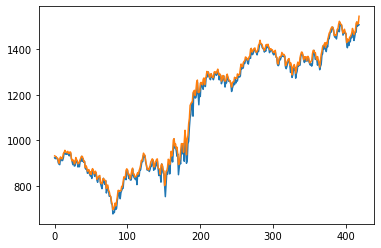

In [50]:
df["Close"].plot()
df["High"].plot()

In [25]:
df["Date"]

12/29/2000  1  320.28  1    340.10
12/28/2000  1  334.22  1    335.93
12/27/2000  1  328.92  1    332.03
12/26/2000  1  315.19  1    315.94
12/22/2000  1  305.97  1    305.97
                             ...  
01/07/2000  1  441.47  1    441.47
01/06/2000  1  403.45  1    411.90
01/05/2000  1  402.11  1    413.27
01/04/2000  1  399.42  1    455.22
01/03/2000  1  455.22  1    478.00
Name: Date, Length: 252, dtype: float64